In [386]:
import numpy as np
import pandas as pd
import re
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import arima_model
from statsmodels.graphics.api import qqplot

In [387]:
def cleanColumnName(column):
    column = re.sub('\W+',' ', column.strip())                     #Remove all symbols from the column name
    column = column.strip()                                        #Remove all whitespaces from the ends of the column name
    return column.lower().replace(" ","_")                         #Replace spaces in between words with '_'

def dateParse(dates):
    pd.datetime.strptime(dates, '%Y-%m-%d')

def test_stationarity(ticker, timeseries):
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=7, center=False).mean()
    rolstd = timeseries.rolling(window=7, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(ticker)
    plt.show(block=False)
    
    #Durbin-Watson Statistic for Autocorrelation
    dftest = durbin_watson(timeseries)
    print(ticker)
    print("Durbin-Watson statistic for "+ticker+": ",dftest)

warnings.filterwarnings('ignore')


### Data Cleansing:

In [388]:
bankrupt_companies = pd.read_csv("public_company_bankruptcy_cases.csv")
companies_stock_prices = pd.read_csv("prices-split-adjusted.csv", parse_dates=True, usecols=["date","symbol","close"], date_parser=dateParse)
nyse_data = pd.read_csv("fundamentals.csv", index_col='Unnamed: 0')

# DATA CLEANING: Removing unnecessary columns from the datasets. This is completely heuristic, since we
# are dropping the columns based purely on our own understanding of their significance.
bankrupt_companies.drop(["DISTRICT", "STATE", "COMPANY NAME"], axis=1, inplace=True)
nyse_data.drop(["Deferred Asset Charges","Deferred Liability Charges","Depreciation","Earnings Before Tax","Effect of Exchange Rate","Equity Earnings/Loss Unconsolidated Subsidiary","Goodwill","Income Tax","Intangible Assets","Interest Expense","Liabilities","Minority Interest","Misc. Stocks","Net Cash Flow-Operating","Net Cash Flows-Financing","Net Cash Flows-Investing","Net Income Adjustments","Net Income Applicable to Common Shareholders","Net Income-Cont. Operations","Operating Income","Operating Margin","Other Assets","Other Current Assets","Other Current Liabilities","Other Financing Activities","Other Investing Activities","Other Liabilities","Other Operating Activities","Other Operating Items","Pre-Tax Margin","Pre-Tax ROE","Research and Development","Total Current Assets","Total Current Liabilities","Total Liabilities & Equity","Treasury Stock", "For Year"], axis=1, inplace=True)

# DATA CLEANING: Making Column Name Formats Consistent
bankrupt_companies.columns = map(cleanColumnName, bankrupt_companies.columns)
bankrupt_companies.columns = ["total_assets", "total_liabilities"]
companies_stock_prices.columns = map(cleanColumnName, companies_stock_prices.columns)
nyse_data.columns = map(cleanColumnName, nyse_data.columns)

nyse_data.head()

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add_l_income_expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,sale_and_purchase_of_stock,sales_general_and_admin,short_term_debt_current_portion_of_long_term_debt,short_term_investments,total_assets,total_equity,total_liabilities,total_revenue,earnings_per_share,estimated_shares_outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,-2.731000e+09,4.500900e+10,2.674300e+10,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322500e+10,2.021000e+09,4.120400e+10,4.265000e+10,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,-3.846000e+09,2.127500e+10,2.231000e+09,5.864000e+09,4.841500e+10,5.635000e+09,4.278000e+10,4.099000e+10,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,-1.860000e+07,2.440721e+09,6.270000e+05,0.000000e+00,4.613814e+09,1.210694e+09,3.403120e+09,6.205003e+09,5.29,7.328355e+07


In [389]:
# Remove NaN values from respective datasets
bankrupt_companies.dropna(axis=0, subset=['total_assets', 'total_liabilities'], inplace=True)

nyse_data.dropna(axis=1, how='any', inplace=True)
nyse_data.dropna(axis=0, how='any', inplace=True)

companies_stock_prices.dropna(axis=0, how='any', inplace=True)

### Training SVM to function as Bankruptcy Predictor:

In [392]:
# Create new dataframe containing data of non-bankrupt companies in 2013
nyse_2013 = nyse_data.loc[nyse_data['period_ending'].str.contains("2013"), ["total_assets", "total_liabilities"]]

# Randomly sample this dataset to get a dataframe containing the data for as many non-bankrupt companies 
# as there are bankrupt companies in the other dataset
nyse_2013 = nyse_2013.sample(n=bankrupt_companies.shape[0], replace=False)

# Assign indexes to the 2013 NYSE dataframe to start after the last index of the bankrupt_companies 
# dataframe to ease the merge operation
nyse_2013.set_index([[x for x in range(bankrupt_companies.index[-1]+1, bankrupt_companies.index[-1]+nyse_2013.shape[0]+1)]], inplace=True)

# Manually adding the column "bankrupt" to the dataset to be used as label 
bankrupt_companies["stability"] = 0
nyse_2013["stability"] = 1

# Merge the bankruptcy and non-bankruptcy dataframes to generate one that can be used for training a classifier.
merged_bankruptcy_dataset = pd.concat([bankrupt_companies, nyse_2013])

# Scaling the data to ensure assets and liabilities are in equivalent ranges
scaler = pp.MinMaxScaler()
scaler.fit(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])
merged_bankruptcy_dataset[["total_assets", "total_liabilities"]] = scaler.transform(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])

# Randomly Splitting the merged dataset into training and test datasets for training the Decision Tree
train_bankruptcy_data, test_bankruptcy_data, train_bankruptcy_target, test_bankruptcy_target = train_test_split(
    merged_bankruptcy_dataset.iloc[:,0:-1], merged_bankruptcy_dataset.iloc[:,-1], 
    test_size=0.25
)

((190, 2), 0.83157894736842108)
((64, 2), 0.8125)


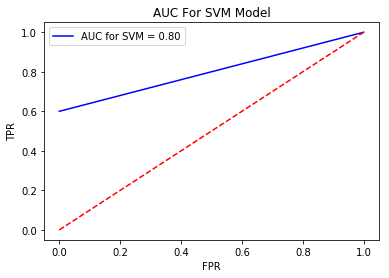

In [393]:
#Training SVM on the training data
Svm_model = svm.LinearSVC()
Svm_model.fit(train_bankruptcy_data, train_bankruptcy_target)

print(train_bankruptcy_data.shape, Svm_model.score(train_bankruptcy_data, train_bankruptcy_target))
print(test_bankruptcy_data.shape, Svm_model.score(test_bankruptcy_data, test_bankruptcy_target))

# Calculating and plotting the ROC and Area-under-curve to understand the classifier accuracy
FPR, TPR, _ = metrics.roc_curve(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))
auc = metrics.auc(FPR, TPR)

plt.plot(FPR, TPR, 'b', label = 'AUC for SVM = %0.2f' %auc)
plt.title("AUC For SVM Model")
plt.legend(loc='best')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [394]:
# Keep only the data for the last year for all companies. We shall be taking only latest data into consideration.
nyse_data.drop_duplicates(subset='ticker_symbol', keep='last', inplace=True)

# Adding in the predicted values for bankruptcy in the original dataset
nyse_data["stability"] = Svm_model.predict(scaler.transform(nyse_data[["total_assets", "total_liabilities"]]))
print "Companies predicted to go bankrupt over a 4 year period: ", len(nyse_data.loc[nyse_data["stability"] != 1, "ticker_symbol"])

Companies predicted to go bankrupt over a 4 year period:  114


### Time Series Analysis:

In [395]:
companies_stock_prices["date"] = pd.to_datetime(companies_stock_prices["date"], format="%Y-%m-%d")
companies_stock_prices.dropna(axis=0, how='any', inplace=True)

# Sorting by ticker symbol
companies_stock_prices.sort_values(by=["symbol", "date"], inplace=True)

# Assuming that the stock trend for each company is distinct, we shall need to model different
# time series for each company by storing the data for each in separate keys in a dictionary.
weekly_stock_prices = {}            # Dictionary to store weekly stock prices for each company

# Add data for each company into separate keys in the dictionary so that time series analysis
# can be run separately for each company.
for i in np.unique(companies_stock_prices["symbol"].values):
    weekly_stock_prices[i] = companies_stock_prices.loc[companies_stock_prices["symbol"] == i, :].copy()
    weekly_stock_prices[i] = weekly_stock_prices[i].reset_index(drop=True)

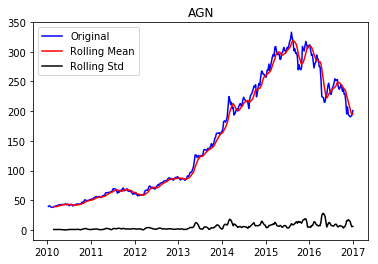

AGN
('Durbin-Watson statistic for AGN: ', array([ 0.00106633]))


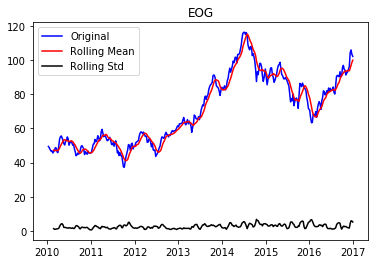

EOG
('Durbin-Watson statistic for EOG: ', array([ 0.00104565]))


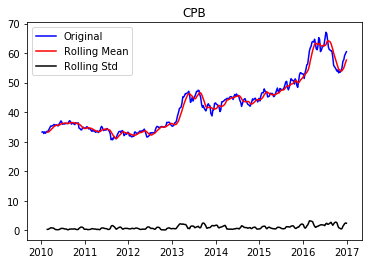

CPB
('Durbin-Watson statistic for CPB: ', array([ 0.00042048]))


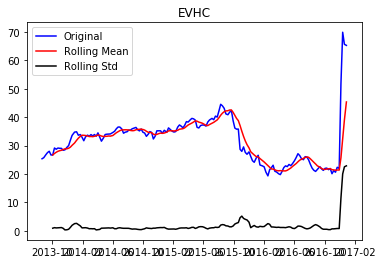

EVHC
('Durbin-Watson statistic for EVHC: ', array([ 0.00806171]))


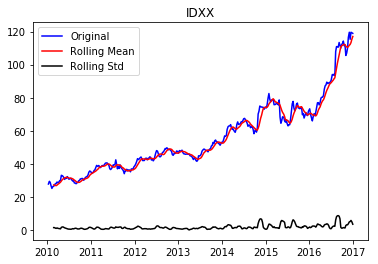

IDXX
('Durbin-Watson statistic for IDXX: ', array([ 0.00094586]))


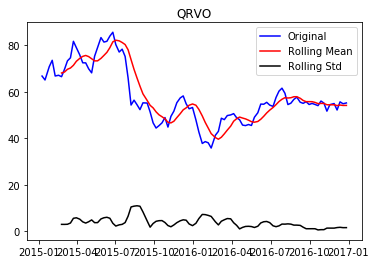

QRVO
('Durbin-Watson statistic for QRVO: ', array([ 0.00290384]))


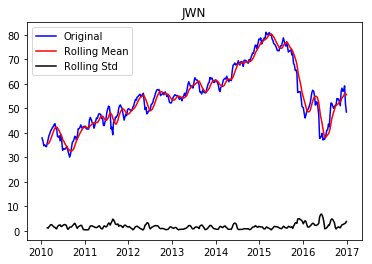

JWN
('Durbin-Watson statistic for JWN: ', array([ 0.00088175]))


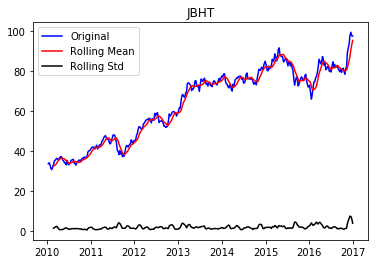

JBHT
('Durbin-Watson statistic for JBHT: ', array([ 0.00059562]))


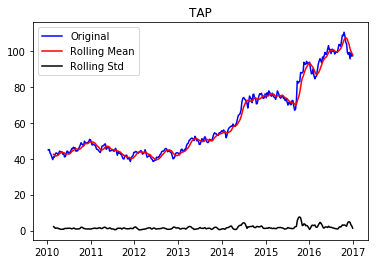

TAP
('Durbin-Watson statistic for TAP: ', array([ 0.00062282]))


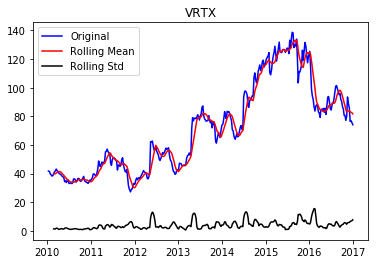

VRTX
('Durbin-Watson statistic for VRTX: ', array([ 0.00270465]))


In [396]:
count = 0
for i in weekly_stock_prices:
    weekly_mean = weekly_stock_prices[i]["close"].rolling(window=5, center=False).mean()[4:]
    # Convert the daily stock data to weekly by keeping only the data for one day a week
    weekly_stock_prices[i] = weekly_stock_prices[i].loc[weekly_stock_prices[i].index % 5 == 0, :]
    weekly_stock_prices[i]["close"] = weekly_mean
    weekly_stock_prices[i].index = weekly_stock_prices[i]["date"]
    weekly_stock_prices[i].drop(["symbol", "date"], axis=1, inplace=True)
    weekly_stock_prices[i].dropna(axis=0, how='any', inplace=True)
    
    count += 1
    # Showing only the first 10 plots since there are ~450 companies, and plotting them all would
    # take a lot of time. Trend and seasonality can be assumed to be present in all of them.
    if count <= 10:
        test_stationarity(i, weekly_stock_prices[i])

As can be expected, stock prices data shows an easily visible trend, and closer inspection reveals the presence of seasonality as well in many cases. The low Durbin-Watson statistic value is evidence of high positive autocorrelation, which is also understandable since stock prices are dependent on previous values. Thus, to run ARIMA analysis on this data, we need to perform operations on it to make it stationary first.

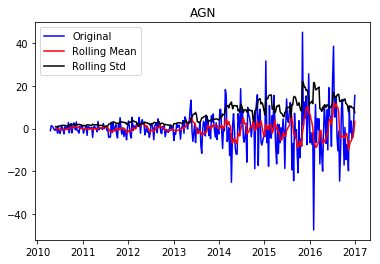

AGN
('Durbin-Watson statistic for AGN: ', 1.8408166958817405)


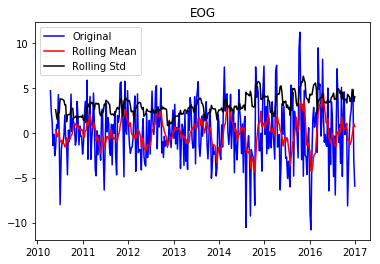

EOG
('Durbin-Watson statistic for EOG: ', 1.6299518594407623)


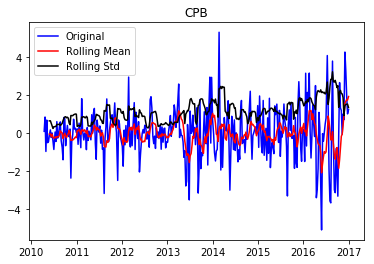

CPB
('Durbin-Watson statistic for CPB: ', 1.5454599084578173)


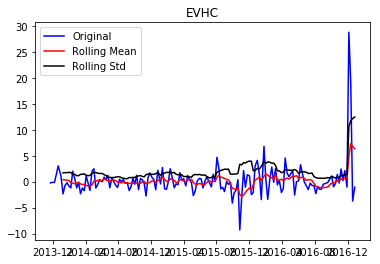

EVHC
('Durbin-Watson statistic for EVHC: ', 1.4213426917002945)


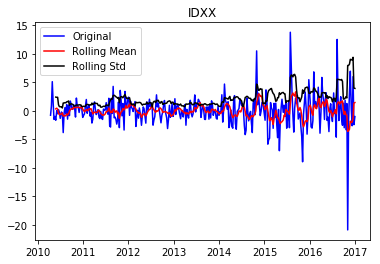

IDXX
('Durbin-Watson statistic for IDXX: ', 1.7448077126902013)


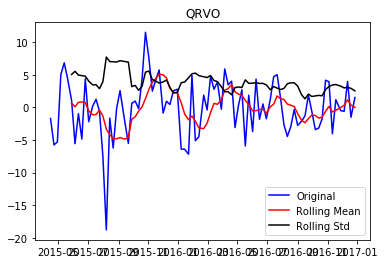

QRVO
('Durbin-Watson statistic for QRVO: ', 1.3805906045088099)


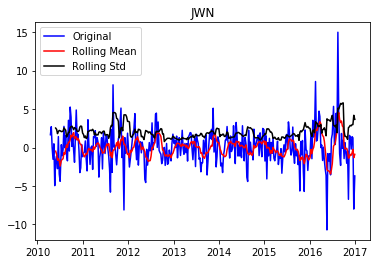

JWN
('Durbin-Watson statistic for JWN: ', 1.6385737145457053)


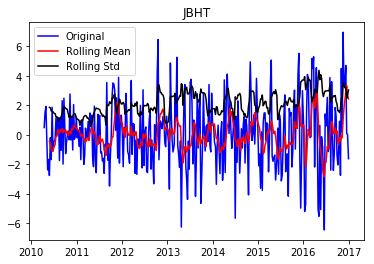

JBHT
('Durbin-Watson statistic for JBHT: ', 1.6966894515415203)


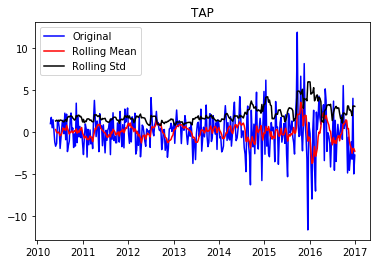

TAP
('Durbin-Watson statistic for TAP: ', 1.8412354264794373)


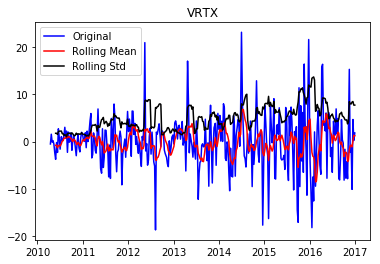

VRTX
('Durbin-Watson statistic for VRTX: ', 1.6067817382582221)


In [397]:
# Making the data stationary

count = 0
weekly_stock_prices_log = {}
for i in weekly_stock_prices:
    # Using Differencing to remove Trend and Seasonality in the data
    weekly_stock_prices_log[i] = weekly_stock_prices[i].copy()
    weekly_stock_prices_log[i]["first_difference"] = weekly_stock_prices_log[i]["close"] - weekly_stock_prices_log[i]["close"].shift(1)
    weekly_stock_prices_log[i]["seasonal_first_difference"] = weekly_stock_prices_log[i]["first_difference"] - weekly_stock_prices_log[i]["first_difference"].shift(12)

    count += 1
    if count <=10:
        test_stationarity(i, weekly_stock_prices_log[i]["seasonal_first_difference"].dropna(inplace=False))

The plots can now be seen to have lost the trend and seasonality that was present in the previous plots. The Durbin-Watson statistic too shows a value ~2, and thus we can conclude that the residuals are stationary and can proceed to perform analysis operations on them.

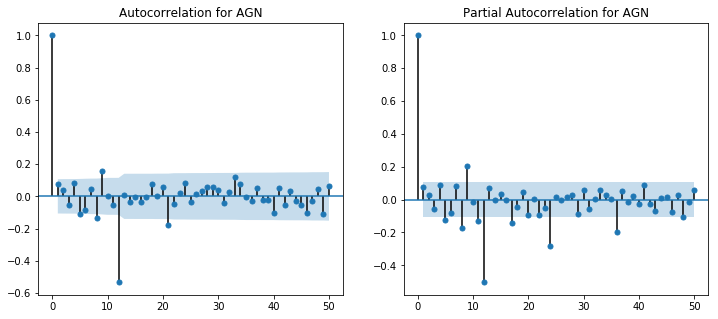

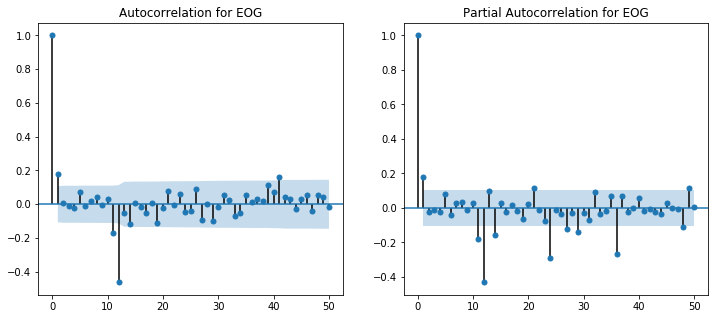

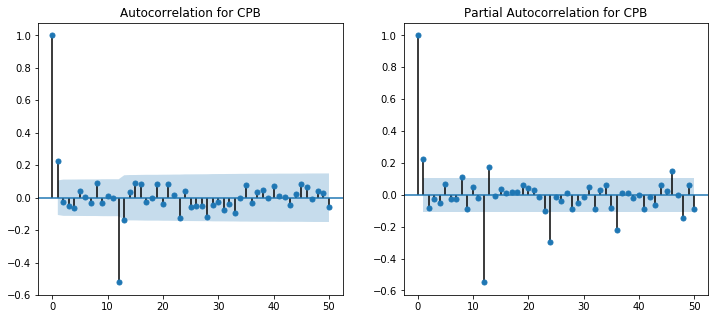

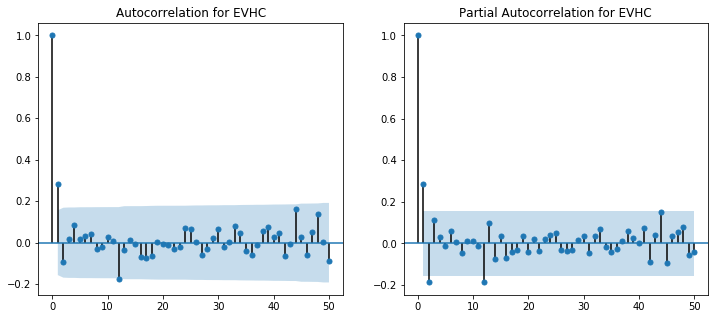

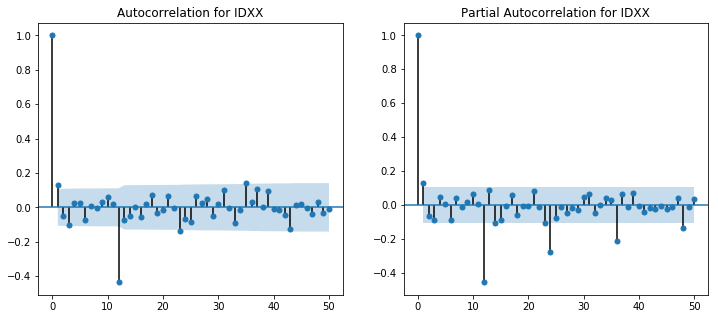

In [398]:
# Decide the Autoregression and Moving Average Parameters by plotting ACF and PACF plots.
count = 0
for i in weekly_stock_prices_log:
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    plot_acf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Autocorrelation for "+i, ax=ax1)
    ax2 = fig.add_subplot(122)
    plot_pacf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Partial Autocorrelation for "+i, ax=ax2)
    count += 1
    if count == 5:
        break
plt.show()

The ACF and PACF plots show a spike at lag 1. The plots are not conclusive themselves however, since none can be said to be exponentially decreasing, as well as showing a number of outliers. Trials using different values for p and q showed significantly better results at (2,1). 


An ACF-PACF analysis for all companies was not possible, hence for instances where the SVD did not converge for (2,1), a fallback value of (1,0) was used. 

('For AGN: ', NormaltestResult(statistic=472.93123930305205, pvalue=2.0150518495630914e-103))


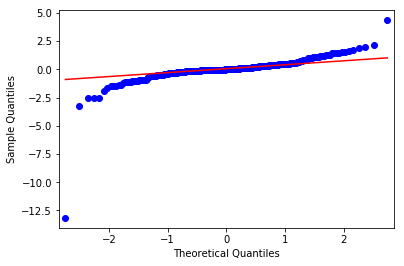

('For EOG: ', NormaltestResult(statistic=120.49648362661878, pvalue=6.8315780758386102e-27))


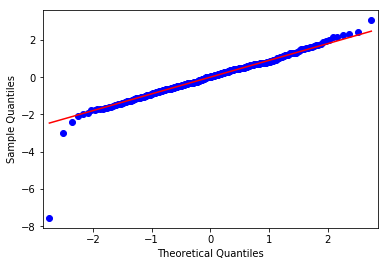

('For CPB: ', NormaltestResult(statistic=339.86796767404019, pvalue=1.579823361925116e-74))


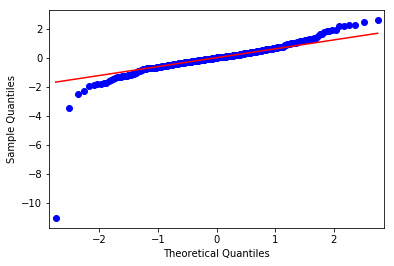

('For EVHC: ', NormaltestResult(statistic=69.17501926644907, pvalue=9.5243516902465695e-16))


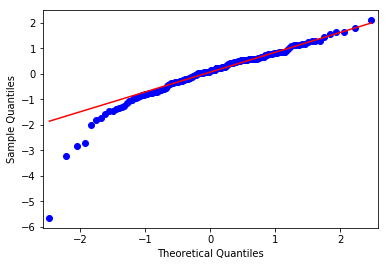

('For IDXX: ', NormaltestResult(statistic=360.2101109972532, pvalue=6.0446092870173276e-79))


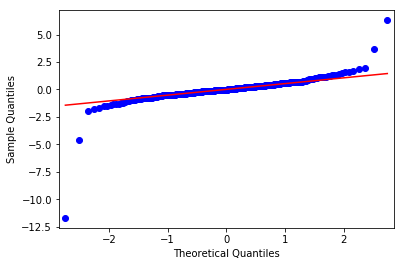

In [399]:
count = 0
stock_predictions = {}
for i in weekly_stock_prices_log:
    # Splitting available data into training for accuracy check using remaining data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    # Number of weeks from last date in dataset to 2018-12-31 = 117
    num_of_predictions = len(weekly_stock_prices_log[i]) + 117
    training = weekly_stock_prices_log[i][0:split_point]
    model = {}
    # Try modelling first using p=2, q=1, if that fails use p=1, q=0
    try:
        model = arima_model.ARMA(training["close"], order=(2,1)).fit()
    except:
        model = arima_model.ARMA(training["close"], order=(1,0)).fit()
    
    #Add the predicted values in a dataframe for ease of further operations.
    daterange = pd.date_range(training.index[0], periods=num_of_predictions, freq = 'W-MON').tolist()
    stock_predictions[i] = pd.DataFrame(columns=["date", "prediction"])
    stock_predictions[i]["date"] = daterange
    stock_predictions[i]["prediction"] = model.predict(start=0, end=num_of_predictions)
    stock_predictions[i].set_index("date", inplace=True)
    
    # Draw a QQPlot to check if the residuals are evenly distributed
    if count < 5:
        resid = model.resid
        print("For "+i+": ",stats.normaltest(resid))
        qqplot(resid, line='q', fit=True)
        plt.show()
        count += 1

The QQ plots show reasonably equal distribution, and we can thus conclude that the residuals analyzed were proper.

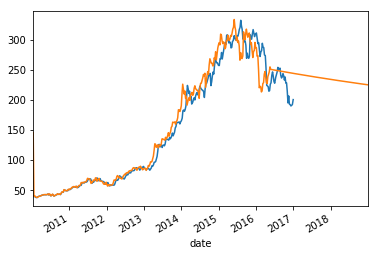

'Mean Absolute Error for AGN: 0.00193187347291'

'Mean Forecast Error for AGN: 0.481341889454'

-------------------------------------------------------------------------------------------------------------------------


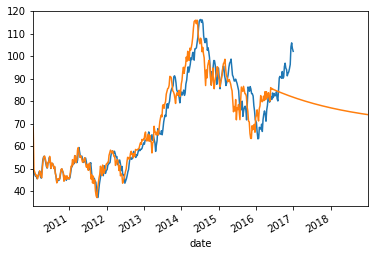

'Mean Absolute Error for EOG: 0.0798100720231'

'Mean Forecast Error for EOG: 6.73902186871'

-------------------------------------------------------------------------------------------------------------------------


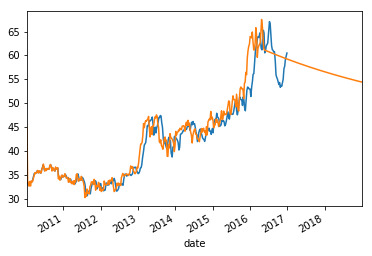

'Mean Absolute Error for CPB: 0.00893546704868'

'Mean Forecast Error for CPB: 0.54092487694'

-------------------------------------------------------------------------------------------------------------------------


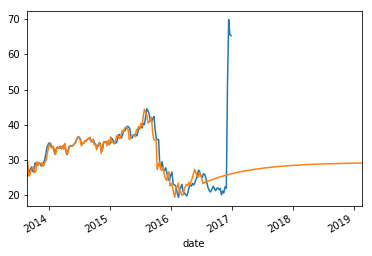

'Mean Absolute Error for EVHC: 0.143090575838'

'Mean Forecast Error for EVHC: -3.51053172619'

-------------------------------------------------------------------------------------------------------------------------


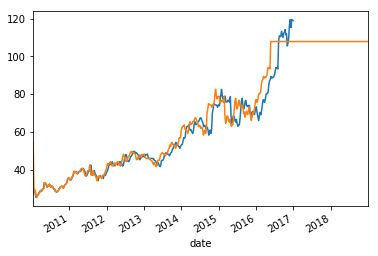

'Mean Absolute Error for IDXX: 0.0264690184111'

'Mean Forecast Error for IDXX: 2.85600695121'

-------------------------------------------------------------------------------------------------------------------------


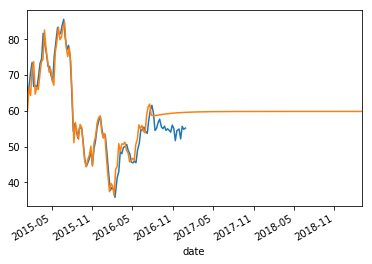

'Mean Absolute Error for QRVO: 0.100785079934'

'Mean Forecast Error for QRVO: -5.95620693487'

-------------------------------------------------------------------------------------------------------------------------


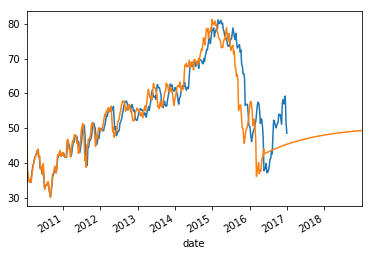

'Mean Absolute Error for JWN: 0.158397127455'

'Mean Forecast Error for JWN: 6.89272442754'

-------------------------------------------------------------------------------------------------------------------------


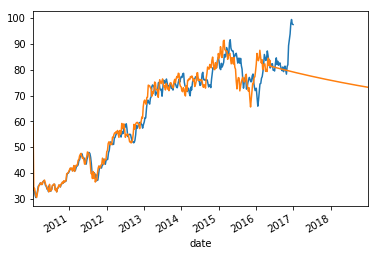

'Mean Absolute Error for JBHT: 0.0206382415512'

'Mean Forecast Error for JBHT: 1.66385893237'

-------------------------------------------------------------------------------------------------------------------------


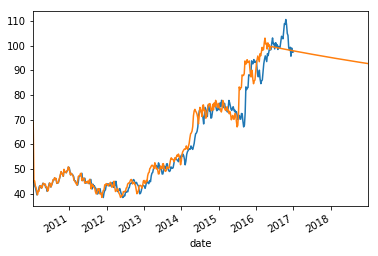

'Mean Absolute Error for TAP: 0.0115749676383'

'Mean Forecast Error for TAP: 1.14684278635'

-------------------------------------------------------------------------------------------------------------------------


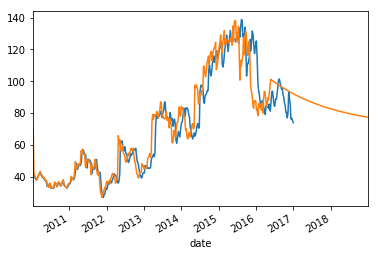

'Mean Absolute Error for VRTX: 0.0246045992625'

'Mean Forecast Error for VRTX: 2.4170609498'

-------------------------------------------------------------------------------------------------------------------------


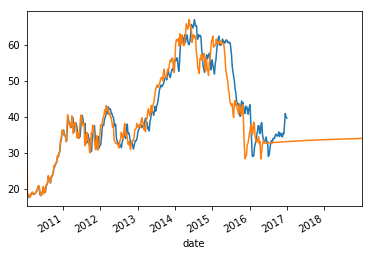

'Mean Absolute Error for BWA: 0.0334229670671'

'Mean Forecast Error for BWA: 1.09813003018'

-------------------------------------------------------------------------------------------------------------------------


In [400]:
# Analysis of the Time Series model
count = 0
for i in weekly_stock_prices_log:
    # Plot actual values against predicted values
    weekly_stock_prices_log[i]["close"].plot()
    stock_predictions[i]["prediction"].plot()
    plt.show()
    
    # Calculate Mean Absolute Error and Mean Forecast Error for Validation data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    forecastedValues = stock_predictions[i]["prediction"].iloc[split_point : len(weekly_stock_prices_log[i])]
    actualValues = weekly_stock_prices_log[i]["close"].iloc[split_point:]
    mfe = actualValues.subtract(forecastedValues).mean()
    mae = (abs(mfe)/forecastedValues).mean()
    display("Mean Absolute Error for "+i+": "+str(mae))
    display("Mean Forecast Error for "+i+": "+str(mfe))
    print "-------------------------------------------------------------------------------------------------------------------------"
    count += 1
    if count > 10:
        break

Mean Absolute Error values ~0 show that the predictions made by the Time Series models had good accuracy.

### Augmenting the Initial Dataset with Predicted Data:

In [401]:
# Create new column to store the predicted stock prices
nyse_data["stock_pred"] = np.nan
for i in stock_predictions:
    # Calculating a percentage metric to estimate the rise or fall of the company's stock -- and
    # consequently the organization's growth -- in order to maintain a fair range across all organizations.
    perc=(stock_predictions[i]["prediction"].tail(105).mean() - stock_predictions[i]["prediction"].tail(105)[0])/stock_predictions[i]["prediction"].tail(105)[0]
    nyse_data.loc[nyse_data["ticker_symbol"] == i, "stock_pred"] = perc

# Add the predicted value of bankruptcy to the predicted stock price to generate a compounded
# label that effectively represents the growth or degeneration of the company.
nyse_data["stock_pred"] += nyse_data["stability"]

# Drop unnecessary and non-numerical columns from dataset for ease of modelling.
nyse_data.drop(["period_ending", "stability", "ticker_symbol"], axis=1, inplace=True)
nyse_data.dropna(axis=0, subset=["stock_pred"], inplace=True)

In [402]:
# Scale the Features of the dataset
nyse_data_scaled = nyse_data.iloc[:,0:-1]
scaler = pp.StandardScaler()
nyse_data_scaled[nyse_data_scaled.columns] = scaler.fit_transform(nyse_data_scaled[nyse_data_scaled.columns])

# Scale the target variable to lie in between the values -1 and 1, rounded up to the nearest tenth place
# and multiplied by 10 to generate a non-continuous multi-valued label.
scaler = pp.MinMaxScaler(feature_range=(-1,1))
nyse_data_target_scaled = scaler.fit_transform(nyse_data.iloc[:,-1].reshape(-1,1)).round(decimals=1) * 10

# Split the augmented dataset into train and test sets for training the classifier.
train_data, test_data, train_target, test_target = train_test_split(nyse_data_scaled, nyse_data_target_scaled, test_size=0.25)

In [403]:
# Training a Random Forest Classifier
RF = RandomForestClassifier()
RF.fit(train_data, train_target)

model_predictions = RF.predict(test_data)

print("Training:-->",train_data.shape, RF.score(train_data, train_target))
print("Testing:-->",test_data.shape, RF.score(test_data, test_target))

('Training:-->', (334, 34), 0.98502994011976053)
('Testing:-->', (112, 34), 0.7410714285714286)


In [404]:
# Analyze the features found by the Random Forest model to correlate most highly
# with the augmented label. Observe the numeric correlation.
top_features = np.argsort(RF.feature_importances_[-5:])
top_features = np.append(top_features, -1)
display(nyse_data.iloc[:, top_features].corr())

,accounts_payable,capital_expenditures,add_l_income_expense_items,accounts_receivable,after_tax_roe,stock_pred
accounts_payable,1.000000,-0.272492,0.108577,0.496666,0.004488,0.166619
capital_expenditures,-0.272492,1.000000,-0.354534,-0.055576,-0.012198,-0.228784
add_l_income_expense_items,0.108577,-0.354534,1.000000,0.029684,-0.007574,0.069909
accounts_receivable,0.496666,-0.055576,0.029684,1.000000,0.001121,0.013290
after_tax_roe,0.004488,-0.012198,-0.007574,0.001121,1.000000,-0.017227
stock_pred,0.166619,-0.228784,0.069909,0.013290,-0.017227,1.000000


In [405]:
# Generate a Confusion Matrix and calculate the Matthews Correlation co-efficienct as
# evaluation metrics for the Random Forest classifier that was trained.
display("CONFUSION MATRIX: ",metrics.confusion_matrix(test_target, model_predictions))
display("MATTHEWS CORRELATION CO-EFFICIENT", metrics.matthews_corrcoef(test_target, model_predictions))

'CONFUSION MATRIX: '

array([[ 1,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 64,  3,  0,  0],
       [ 0,  1,  0,  0,  0,  7,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0]])

'MATTHEWS CORRELATION CO-EFFICIENT'

0.53348354519442676